# Pylops - Wavefield separation with cupy

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from scipy.signal import convolve, filtfilt
from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops.utils.seismicevents import *
from pylops.utils.wavelets import *
from pylops.utils.tapers import *
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.optimization.basic import *

np.random.seed(10)

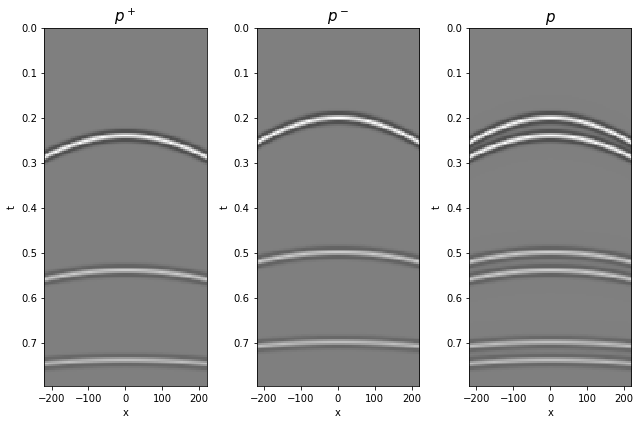

In [2]:
###### Input parameters
par = {'ox':-220,  'dx':5,    'nx':89,
       'oy':-300,  'dy':5,    'ny':121,
       'ot':0,     'dt':0.004, 'nt':200,
       'f0': 40}

t0_minus = np.array([0.2,0.5,0.7])
t0_plus = t0_minus + 0.04
vrms = np.array([1400.,1500., 2000.])
amp = np.array([1.,0.6,0.5])
vel_sep = 900.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Create data
_, p_minus = hyperbolic2d(x, t, t0_minus, vrms, amp, wav)
_, p_plus = hyperbolic2d(x, t, t0_plus, vrms, amp, wav)
p = p_plus + p_minus

p_minus = cp.array(p_minus)
p_plus = cp.array(p_plus)
p = cp.array(p)

plt.figure(figsize=(9,6))
plt.subplot(131)
plt.imshow(cp.asnumpy(p_plus).T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p^+$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(132)
plt.imshow(cp.asnumpy(p_minus).T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p^-$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

plt.subplot(133)
plt.imshow(cp.asnumpy(p).T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p$', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

In [3]:
nfft=2**11
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nt']*par['nx'], complexflag=2, backend='cupy')

P = FFTop*p.flatten()
P = P.reshape(nfft, nfft)

## Wavefield composition

/tmp/ipykernel_35054/743340021.py:11: RuntimeWarning: divide by zero encountered in true_divide
  OBL=rho_sep*(np.abs(F)/Kz)
/tmp/ipykernel_35054/743340021.py:11: RuntimeWarning: invalid value encountered in true_divide
  OBL=rho_sep*(np.abs(F)/Kz)
/tmp/ipykernel_35054/743340021.py:20: RuntimeWarning: divide by zero encountered in true_divide
  OBL1 = Kz /(rho_sep*np.abs(F))
/tmp/ipykernel_35054/743340021.py:20: RuntimeWarning: invalid value encountered in true_divide
  OBL1 = Kz /(rho_sep*np.abs(F))


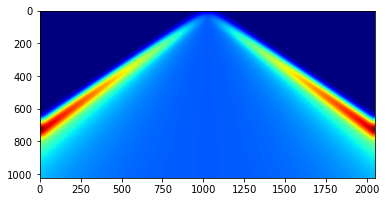

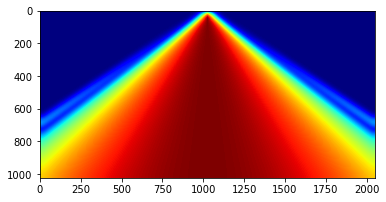

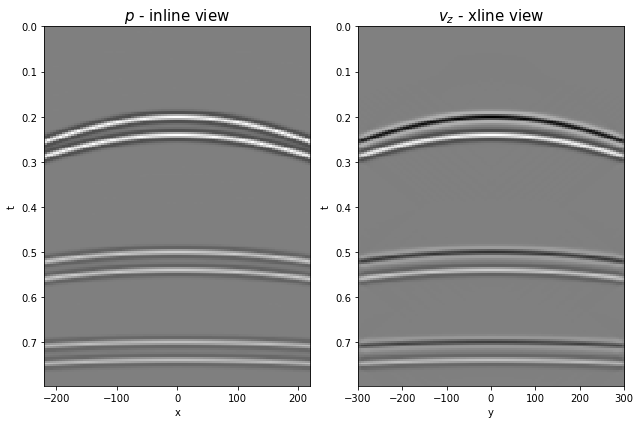

In [4]:
critical = 1.1
ntaper = 51

#obliquity factor
[Kx, F] = np.meshgrid(FFTop.f1, FFTop.f2, indexing='ij')
k=F/vel_sep
#Kz=np.sqrt(k**2-Kx**2)
Kz=np.sqrt((k**2-Kx**2).astype('complex128'))
Kz[np.isnan(Kz)] = 0

OBL=rho_sep*(np.abs(F)/Kz)
OBL[Kz==0]=0

# cut off and taper
mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
OBL = OBL*mask
OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=0)
OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=1)

OBL1 = Kz /(rho_sep*np.abs(F))
OBL1[F==0] = 0
OBL1 = OBL1*mask
OBL1 = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL1, axis=0)
OBL1 = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL1, axis=1)

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL[:, :nfft//2-1]),axes=0).T, cmap='jet')   
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(OBL1[:, :nfft//2-1]),axes=0).T, cmap='jet')   

OBL = cp.array(OBL)
OBL1 = cp.array(OBL1)
OBLop = Diagonal(OBL1.flatten(), dtype='complex128')

# wavefield modelling
S1op = (BlockDiag([FFTop.H, FFTop.H])*\
        Block([[Identity(nfft*nfft, dtype='complex128'), Identity(nfft*nfft, dtype='complex128')],
               [OBLop, -OBLop]])*\
        BlockDiag([FFTop, FFTop]))
dottest(S1op, 2*par['nt']*par['nx'], 2*par['nt']*par['nx'], atol=1e-4, backend='cupy')

p_sep = np.concatenate((p_plus.flatten(), p_minus.flatten()))
d = S1op * p_sep.flatten()
d = np.real(d.reshape(2*par['nx'], par['nt']))
p, vz = d[:par['nx']], d[par['nx']:]

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(cp.asnumpy(p).T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p$ - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(cp.asnumpy(vz).T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title(r'$v_z$ - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

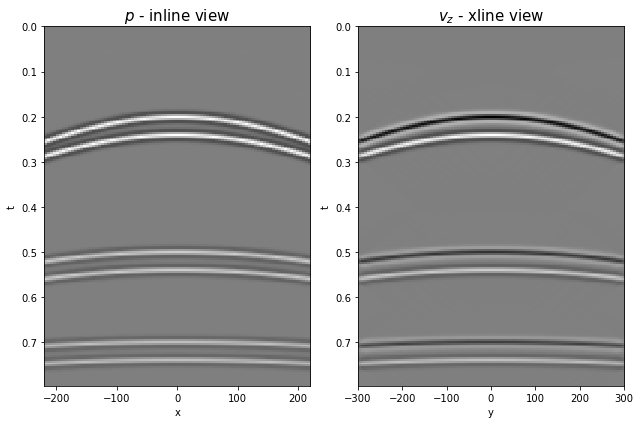

In [5]:
S1op_scaled = (BlockDiag([FFTop.H, float(1./vz.max())*FFTop.H]) *\
               Block([[Identity(nfft*nfft, dtype='complex128'), Identity(nfft*nfft, dtype='complex128')],
               [OBLop, -OBLop]])* BlockDiag([FFTop, FFTop]))

d_scaled = S1op_scaled * p_sep.flatten()
d_scaled = np.real(d_scaled.reshape(2*par['nx'], par['nt']))
p, vz_scaled = d_scaled[:par['nx']], d_scaled[par['nx']:]

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(cp.asnumpy(p).T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$p$ - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(cp.asnumpy(vz_scaled).T, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()), vmin=-1, vmax=1)
plt.title(r'$v_z$ - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

## Analytical separation

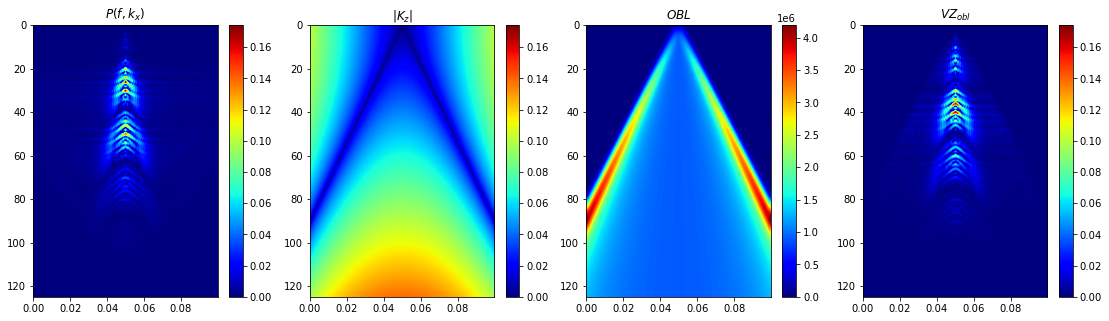

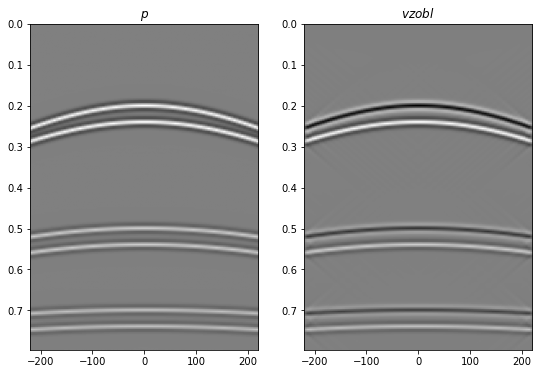

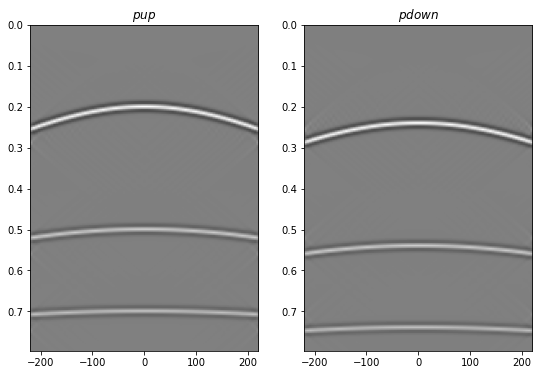

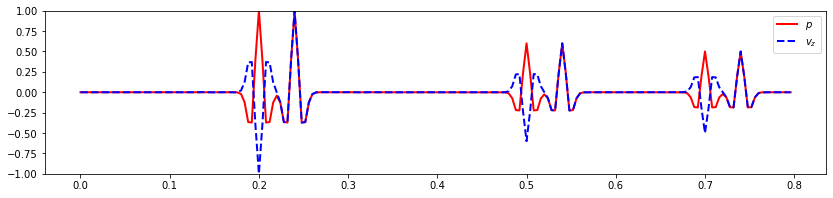

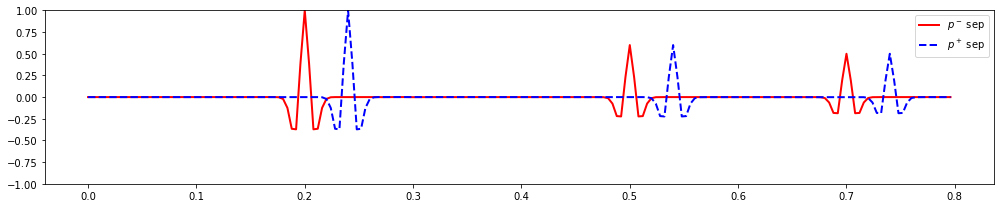

In [6]:
VZ = FFTop*vz.flatten()
VZ = VZ.reshape(nfft, nfft)

# scaled Vz
VZ_obl = OBL*VZ
vz_obl = FFTop.H*VZ_obl.flatten()
vz_obl = np.real(vz_obl.reshape(par['nx'], par['nt']))

p = FFTop.H*P.flatten()
p = np.real(p.reshape(par['nx'], par['nt']))

# separation
pup_sep=(p-vz_obl)/2;
pdown_sep=(p+vz_obl)/2;


fig, axs = plt.subplots(1, 4, figsize=(19,5))
im=axs[0].imshow(cp.asnumpy(np.fft.fftshift(np.abs(P[:, :nfft//2-1]),axes=0)).T, cmap='jet', interpolation='sinc',
             extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
             vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P(f, k_x)$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(cp.asnumpy(np.fft.fftshift(np.abs(Kz[:, :nfft//2-1]),axes=0)).T, cmap='jet', interpolation='sinc',
             extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
             vmin=0, vmax=np.abs(P).max())
axs[1].set_title(r'$|K_z|$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(cp.asnumpy(np.fft.fftshift(np.abs(OBL[:, :nfft//2-1]),axes=0)).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[2].set_title(r'$OBL$')
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2])
im=axs[3].imshow(cp.asnumpy(np.fft.fftshift(np.abs(VZ_obl[:, :nfft//2-1]),axes=0)).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(P).max())
axs[3].set_title(r'$VZ_{obl}$')
axs[3].axis('tight')
plt.colorbar(im, ax=axs[3])

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(p).T, cmap='gray',            
              extent=(x.min(),x.max(),t.max(),t.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(vz_obl).T, cmap='gray',            
              extent=(x.min(),x.max(),t.max(),t.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(pup_sep).T, cmap='gray',            
              extent=(x.min(),x.max(),t.max(),t.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(pdown_sep).T, cmap='gray',            
              extent=(x.min(),x.max(),t.max(),t.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(p)[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, cp.asnumpy(vz_obl)[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(pup_sep)[par['nx']//2], 'r', lw=2, label=r'$p^-$ sep')
plt.plot(t, cp.asnumpy(pdown_sep)[par['nx']//2], '--b', lw=2, label=r'$p^+$ sep')
plt.ylim(-1, 1)
plt.legend()
plt.tight_layout()

/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:138: RuntimeWarning: divide by zero encountered in true_divide
  OBL = rho * (np.abs(F) / Kz)
/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:138: RuntimeWarning: invalid value encountered in true_divide
  OBL = rho * (np.abs(F) / Kz)


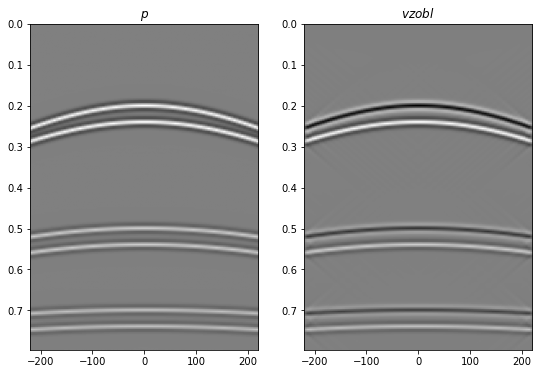

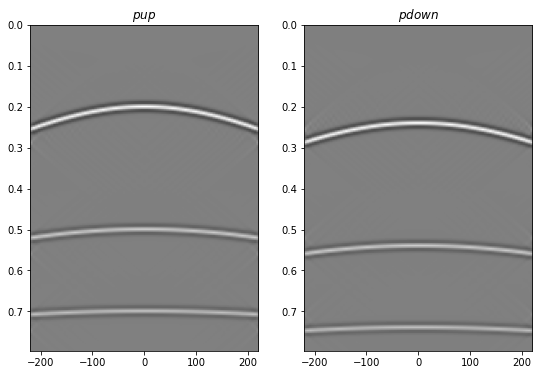

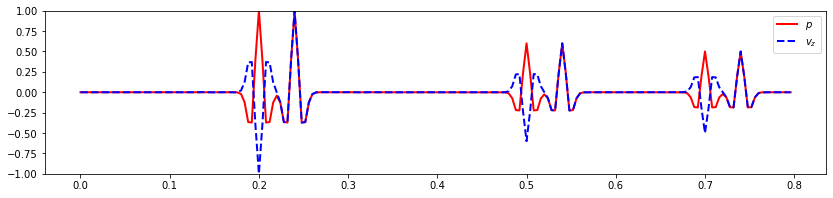

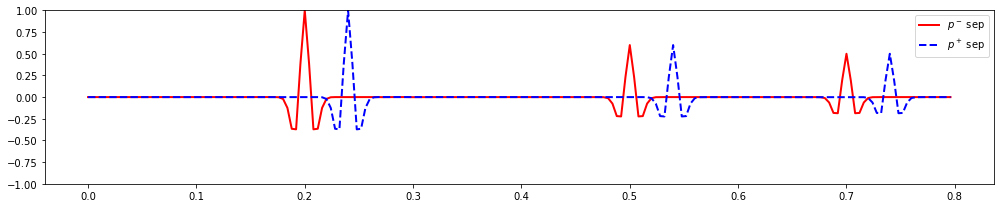

In [7]:
pup_sep, pdown_sep = \
    WavefieldDecomposition(p, vz, par['nt'], par['nx'], par['dt'], par['dx'], 
                           rho_sep, vel_sep, nffts=(nfft, nfft), kind='analytical',
                           critical=critical*100, ntaper=ntaper,
                           dtype='complex128')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(p).T, cmap='gray',            
              extent=(x.min(),x.max(),t.max(),t.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(vz_obl).T, cmap='gray',            
              extent=(x.min(),x.max(),t.max(),t.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(pup_sep).T, cmap='gray',            
              extent=(x.min(),x.max(),t.max(),t.min()), 
              vmin=-1, vmax=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(pdown_sep).T, cmap='gray',            
              extent=(x.min(),x.max(),t.max(),t.min()), 
              vmin=-1, vmax=1)
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(p)[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, cp.asnumpy(vz_obl)[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(pup_sep)[par['nx']//2], 'r', lw=2, label=r'$p^-$ sep')
plt.plot(t, cp.asnumpy(pdown_sep)[par['nx']//2], '--b', lw=2, label=r'$p^+$ sep')
plt.ylim(-1, 1)
plt.legend()
plt.tight_layout()

## Wavefield separation by inversion

CGLS
-----------------------------------------------------------------
The Operator Op has 35600 rows and 35600 cols
damp = 1.000000e-20	tol = 1.000000e-04	niter = 50
-----------------------------------------------------------------

    Itn             x[0]             r1norm         r2norm
     1       -4.45e-06+1.75e-06j    1.4811e+00     1.4811e+00
     2       -2.65e-06-2.15e-06j    4.8801e-01     4.8801e-01
     3       4.50e-06-1.65e-06j    2.6091e-01     2.6091e-01
     4       -2.64e-06+1.11e-06j    1.6848e-01     1.6848e-01
     5       -7.89e-06-1.11e-06j    1.2123e-01     1.2123e-01
     6       5.49e-06-3.58e-06j    9.4106e-02     9.4106e-02
     7       -1.82e-06-1.83e-06j    7.7140e-02     7.7140e-02
     8       -1.10e-05-1.03e-06j    6.6198e-02     6.6198e-02
     9       1.41e-05-2.60e-06j    5.8850e-02     5.8850e-02
    10       1.41e-05-3.36e-06j    5.3236e-02     5.3236e-02
    11       -1.21e-05-3.33e-06j    4.8812e-02     4.8812e-02

Iterations = 14        Total

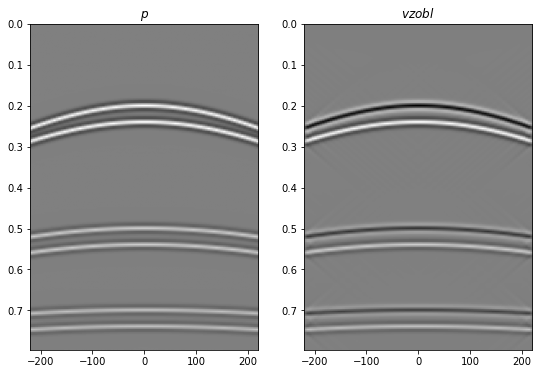

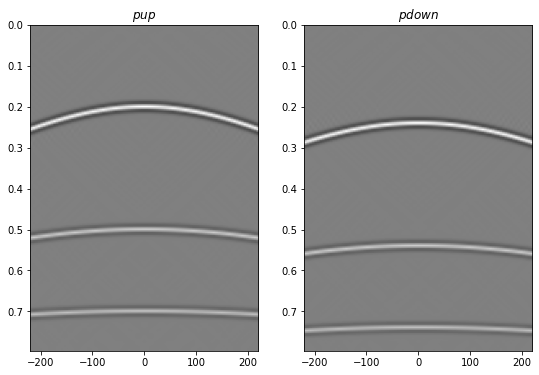

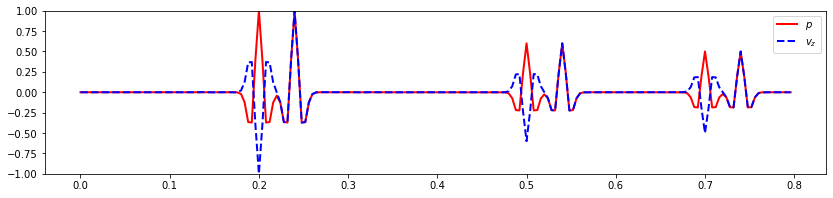

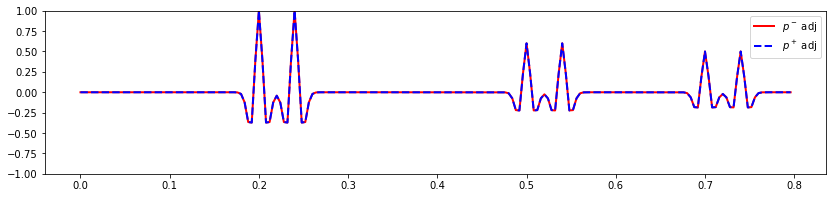

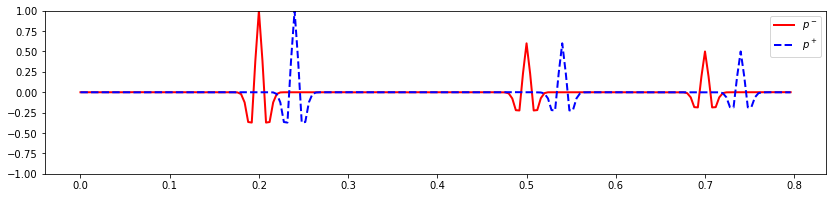

In [8]:
# adjoint and inverse
dud_adj = np.real(S1op_scaled.H * d.flatten())
dud_inv, istop, itn, r1norm, r2norm = cgls(S1op_scaled, d_scaled.flatten(), 
                                           x0=cp.zeros(S1op_scaled.shape[1], 
                                                       dtype=S1op_scaled.dtype),
                                           damp=1e-10, niter=50, show=True)[0:5]
dud_inv = np.real(dud_inv)

dud_adj = dud_adj.reshape(2*par['nx'], par['nt'])
dud_inv = dud_inv.reshape(2*par['nx'], par['nt'])

pdown_adj, pup_adj = dud_adj[:par['nx']], dud_adj[par['nx']:]
pdown_inv, pup_inv = dud_inv[:par['nx']], dud_inv[par['nx']:]

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(p).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(vz_obl).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vzobl$')
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(pup_inv).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(pdown_inv).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(p)[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, cp.asnumpy(vz_obl)[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(pup_adj)[par['nx']//2], 'r', lw=2, label=r'$p^-$ adj')
plt.plot(t, cp.asnumpy(pdown_adj)[par['nx']//2], '--b', lw=2, label=r'$p^+$ adj')
plt.ylim(-1, 1)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(pup_inv)[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, cp.asnumpy(pdown_inv)[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:135: RuntimeWarning: divide by zero encountered in true_divide
  OBL = Kz / (rho * np.abs(F))
/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:135: RuntimeWarning: invalid value encountered in true_divide
  OBL = Kz / (rho * np.abs(F))


 
LSQR            Least-squares solution of  Ax = b
The matrix A has 35600 rows and 35600 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 0.00e+00                 conlim = 1.00e+08
btol = 0.00e+00               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.118e+01  2.118e+01    1.0e+00  6.7e-02


/home/ravasim/miniconda3/envs/pylops_cupy_cusignal_3090/lib/python3.9/site-packages/scipy/sparse/linalg/isolve/lsqr.py:548: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


     1 -5.78733e-18   2.280e-05  2.280e-05    1.1e-06  1.1e-06   1.4e+00  1.0e+00
     2 -1.19780e-11   2.280e-05  2.280e-05    1.1e-06  2.4e-03   1.4e+00  2.3e+03
     3 -4.52615e-06   1.552e-06  1.552e-06    7.3e-08  6.5e-07   2.0e+00  1.3e+06
     4 -4.38955e-06   1.503e-06  1.503e-06    7.1e-08  1.8e-01   2.0e+00  1.4e+06
     5 -2.59422e-06   5.344e-07  5.344e-07    2.5e-08  3.8e-07   2.4e+00  2.4e+06
     6  4.57905e-06   2.878e-07  2.878e-07    1.4e-08  9.5e-03   2.4e+00  3.3e+06
     7  4.57984e-06   2.877e-07  2.877e-07    1.4e-08  2.8e-07   2.8e+00  3.8e+06
     8 -2.71408e-06   1.863e-07  1.863e-07    8.8e-09  1.7e-05   2.8e+00  4.9e+06
     9 -2.71408e-06   1.863e-07  1.863e-07    8.8e-09  2.1e-07   3.2e+00  5.5e+06
    10 -7.87244e-06   1.342e-07  1.342e-07    6.3e-09  1.9e-07   3.2e+00  6.7e+06
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1norm = 1.3e-07   anorm = 3.2e+00   arnorm = 8.1e-14
itn   =      10   r2norm = 1.3e

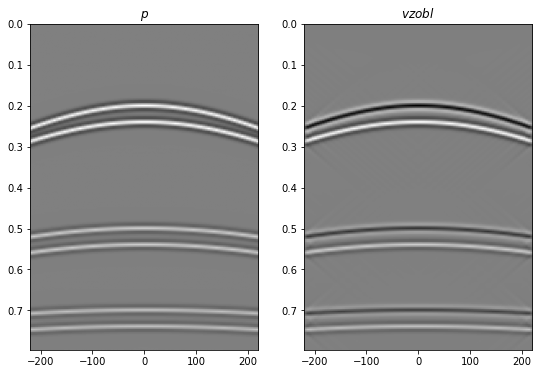

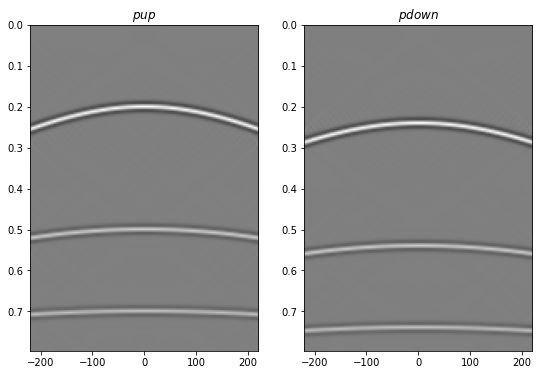

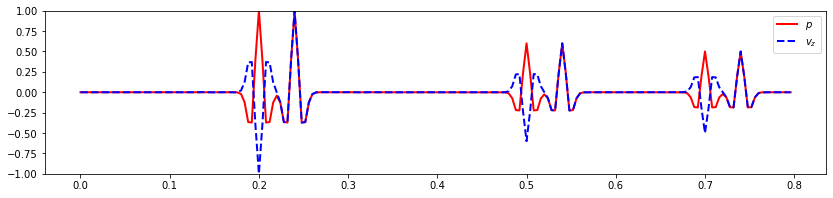

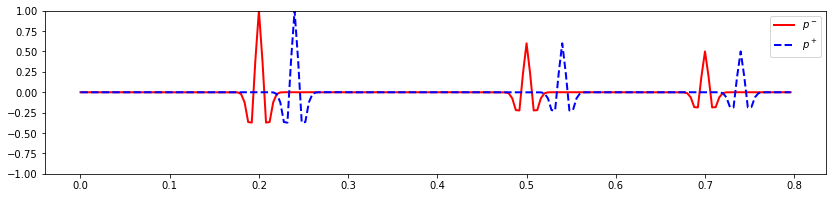

In [9]:
# NUMPY
pup_inv, pdown_inv = WavefieldDecomposition(cp.asnumpy(p), cp.asnumpy(vz), par['nt'], par['nx'], par['dt'], par['dx'], 
                                            rho_sep, vel_sep, nffts=(nfft, nfft), kind='inverse',
                                            critical=critical*100, ntaper=ntaper,
                                            dtype='complex128', **dict(iter_lim=10, atol=0, btol=0, show=True))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(p).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(vz_obl).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vzobl$')
#axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv.T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(p)[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, cp.asnumpy(vz_obl)[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()

plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:135: RuntimeWarning: divide by zero encountered in true_divide
  OBL = Kz / (rho * np.abs(F))
/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:135: RuntimeWarning: invalid value encountered in true_divide
  OBL = Kz / (rho * np.abs(F))


CGLS
-----------------------------------------------------------------
The Operator Op has 35600 rows and 35600 cols
damp = 0.000000e+00	tol = 0.000000e+00	niter = 10
-----------------------------------------------------------------

    Itn             x[0]             r1norm         r2norm
     1       8.67e-19+1.08e-17j    2.2796e-05     2.2796e-05
     2       -5.55e-11+5.50e-12j    2.2796e-05     2.2796e-05
     3       -4.53e-06+1.78e-06j    1.5521e-06     1.5521e-06
     4       -4.53e-06+1.78e-06j    1.5521e-06     1.5521e-06
     5       -2.59e-06-2.24e-06j    5.3441e-07     5.3441e-07
     6       -2.59e-06-2.24e-06j    5.3441e-07     5.3441e-07
     7       4.58e-06-1.62e-06j    2.8772e-07     2.8772e-07
     8       4.58e-06-1.62e-06j    2.8772e-07     2.8772e-07
     9       -2.71e-06+1.12e-06j    1.8627e-07     1.8627e-07
    10       -2.71e-06+1.12e-06j    1.8627e-07     1.8627e-07

Iterations = 10        Total time (s) = 0.29
--------------------------------------------

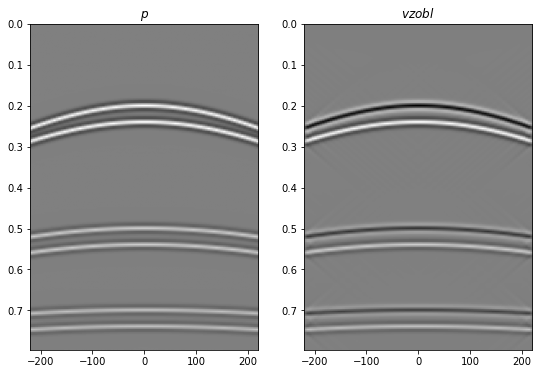

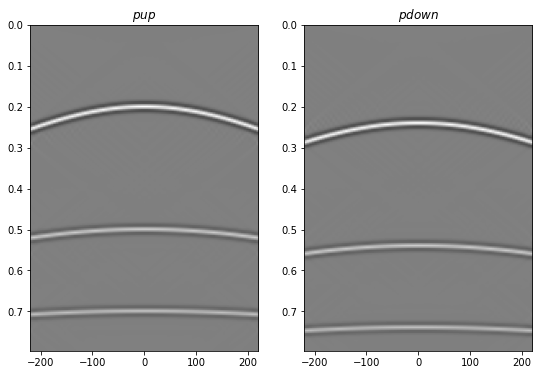

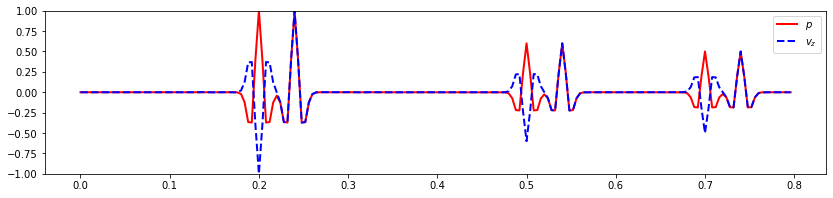

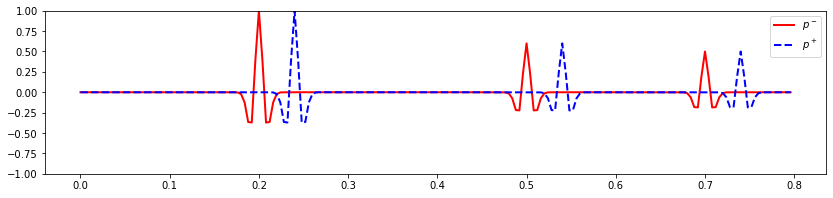

In [10]:
# CUPY
pup_inv, pdown_inv = WavefieldDecomposition(p, vz, par['nt'], par['nx'], par['dt'], par['dx'], 
                                            rho_sep, vel_sep, nffts=(nfft, nfft), kind='inverse',
                                            critical=critical*100, ntaper=ntaper, solver=cgls,
                                            dtype='complex128', 
                                            **dict(x0=cp.zeros(2*p.size, dtype='complex128'), 
                                                   niter=10, tol=0, show=True))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(p).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(vz_obl).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vzobl$')
#axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(cp.asnumpy(pup_inv).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(pdown_inv).T, cmap='gray', vmin=-np.abs(p).max(), vmax=np.abs(p).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(p)[par['nx']//2], 'r', lw=2, label=r'$p$')
plt.plot(t, cp.asnumpy(vz_obl)[par['nx']//2], '--b', lw=2, label=r'$v_z$')
plt.ylim(-1, 1)
plt.legend()

plt.figure(figsize=(14, 3))
plt.plot(t, cp.asnumpy(pup_inv)[par['nx']//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, cp.asnumpy(pdown_inv)[par['nx']//2], '--b', lw=2, label=r'$p^+$')
plt.ylim(-1, 1)
plt.legend();

# Recomposition

/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:135: RuntimeWarning: divide by zero encountered in true_divide
  OBL = Kz / (rho * np.abs(F))
/home/ravasim/Documents/OpenSource/pylops/pylops/waveeqprocessing/wavedecomposition.py:135: RuntimeWarning: invalid value encountered in true_divide
  OBL = Kz / (rho * np.abs(F))


(-220.0, 220.0, 0.796, 0.0)

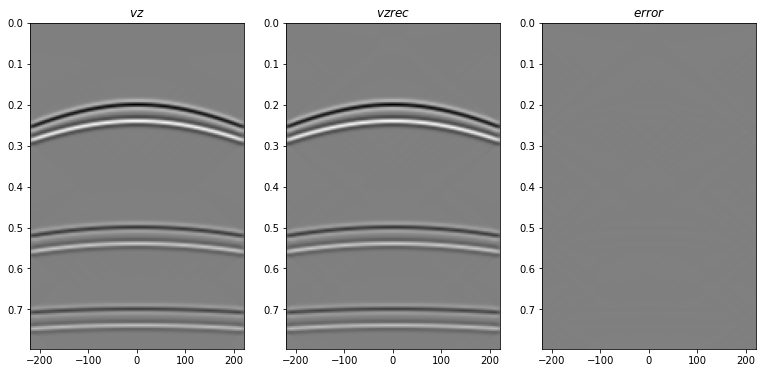

In [11]:
# NUMPY
PtoVop = PressureToVelocity(par['nt'], par['nx'], par['dt'], par['dx'], 
                            rho_sep, vel_sep, nffts=(nfft, nfft), 
                            critical=critical*100., ntaper=ntaper, topressure=False)

vdown_rec =  (PtoVop * cp.asnumpy(pdown_inv).ravel()).reshape(par['nx'], par['nt'])
vup_rec = (PtoVop * cp.asnumpy(pup_inv).ravel()).reshape(par['nx'], par['nt'])
vz_rec = np.real(vdown_rec - vup_rec)

fig, axs = plt.subplots(1, 3, figsize=(13, 6))
axs[0].imshow(cp.asnumpy(vz).T, cmap='gray', vmin=-np.abs(vz).max(), vmax=np.abs(vz).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$vz$')
axs[0].axis('tight')
axs[1].imshow(vz_rec.T, cmap='gray', vmin=-np.abs(vz).max(), vmax=np.abs(vz).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vz rec$')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(vz).T - vz_rec.T, cmap='gray', vmin=-np.abs(vz).max(), vmax=np.abs(vz).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[2].set_title(r'$error$')
axs[2].axis('tight');

(-220.0, 220.0, 0.796, 0.0)

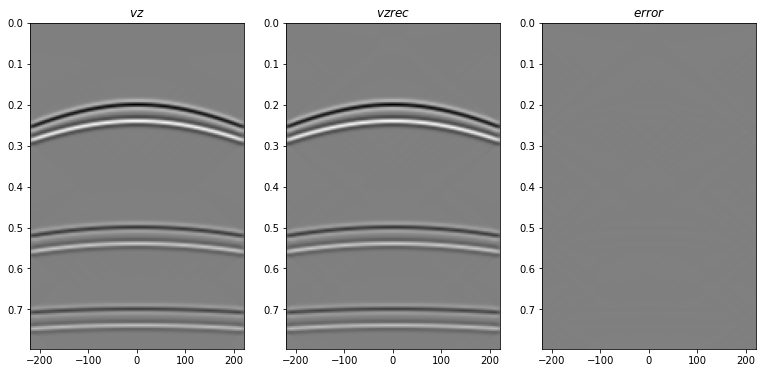

In [12]:
# CUPY
PtoVop = PressureToVelocity(par['nt'], par['nx'], par['dt'], par['dx'], 
                            rho_sep, vel_sep, nffts=(nfft, nfft), 
                            critical=critical*100., ntaper=ntaper, 
                            topressure=False, backend='cupy')

vdown_rec =  (PtoVop * pdown_inv.ravel()).reshape(par['nx'], par['nt'])
vup_rec = (PtoVop * pup_inv.ravel()).reshape(par['nx'], par['nt'])
vz_rec = np.real(vdown_rec - vup_rec)

fig, axs = plt.subplots(1, 3, figsize=(13, 6))
axs[0].imshow(cp.asnumpy(vz).T, cmap='gray', vmin=-np.abs(vz).max(), vmax=np.abs(vz).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[0].set_title(r'$vz$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(vz_rec).T, cmap='gray', vmin=-np.abs(vz).max(), vmax=np.abs(vz).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[1].set_title(r'$vz rec$')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(vz).T - cp.asnumpy(vz_rec).T, cmap='gray', vmin=-np.abs(vz).max(), vmax=np.abs(vz).max(),
              extent = (x.min(),x.max(),t.max(),t.min()))
axs[2].set_title(r'$error$')
axs[2].axis('tight');